# NLP Final Project

John Abreu, Pedro Guimaraes, Israel Montiel, and Michelle Youn

In [187]:
import json, os, time, re, csv, sys
import pandas as pd
import numpy as np
import urllib.request as urllib2

import nltk
import sklearn
import gensim
import scipy as sp
import seaborn

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

# Assumptions
1. All of the song are in English (a few are not, and some have verses in other languages)
2. Slang words ending with "-in" replaced with "-ing"

In [2]:
os.getcwd() #'/Users/michelleyoun/Desktop/nlp'

'/Users/michelleyoun/Desktop/nlp'

# Heroku API Example 

Sample API call using song title and artist

In [3]:
# Example: John Lennon's Imagine

data = json.load(urllib2.urlopen('http://lyric-api.herokuapp.com/api/find/John%20Lennon/Imagine'))
print(data['lyric'])

Imagine there's no heaven
It's easy if you try
No hell below us
Above us only sky

Imagine all the people
Living for today

Imagine there's no countries
It isn't hard to do
Nothing to kill or die for
And no religion too

Imagine all the people
Living life in peace

You may say I'm a dreamer
But I'm not the only one
I hope someday you'll join us
And the world will be as one

Imagine no possessions
I wonder if you can
No need for greed or hunger
A brotherhood of man

Imagine all the people
Sharing all the world

You may say I'm a dreamer
But I'm not the only one
I hope someday you'll join us
And the world will live as one


# Scraping Lyrics - 1st Pass

In [601]:
# Original: https://github.com/kevinschaich
# Modified by Michelle Youn for compatability with Python3 and Heroku API


# Change directory
os.chdir('/Users/michelleyoun/Desktop/nlp/billboard')


# Track missed songs
# keys: year, value: position
years = range(1950, 2016)
missed = {k: [] for k in years}


# Iterate through years 1950 - 2015
for year in range(2015, 1949, -1):
    print("\nFinding lyrics for year: " + str(year) + "\n")
    
    # Original file 
    file_name = str(year) + ".csv"

    # Get all song titles and associated artists
    df = pd.read_csv(file_name, encoding = "ISO-8859-1")
    
    # Add "Lyric" column
    df['Lyrics'] = ''
    
    # Eliminate spaces column name
    df.columns = [c.replace(' ', '_') for c in df.columns]

    count = 0
    
    # For each song, get metadata
    for index, row in df.iterrows():
        pos_col = df.columns[0]
        pos = row[pos_col]
        artist = row['Artist']
        song_title = row['Song_Title']
        
        # Remove featured artist
        artist = re.sub(r'feat.*', '', artist)
        artist = re.sub(r'ft\..*', r'', artist)
        
        song_title = re.sub("\[\(\).*\]", "", song_title).strip()
        
        # Replace all spaces with %20
        artist = re.sub(r'\s+', '%20', artist)
        song_title = re.sub(r"\s+", "%20", song_title)
        
        if artist.endswith('%20'):
            artist = artist[:-3]
        
        # Prep URL link
        url = 'http://lyric-api.herokuapp.com/api/find/' + str(artist) + '/' + str(song_title)
        # print(url)
        
        # Load URL
        try: 
            data = json.load(urllib2.urlopen(url))
            lyric = data['lyric']
            df.at[index,'Lyrics'] = lyric
    
        except (urllib2.HTTPError, NameError, UnicodeDecodeError):
            # missed[year].append(pos)
            pass
            
        # CHECK: If lyrics did not load or are missing, add to missed 
        if not df.at[index,'Lyrics']:
            missed[year].append(pos)
            # print(artist, song_title)
            
#         if (count % 20) == 0:
#             print(count)
            
        count += 1
    
    # Save intermediary lyric files
    save_file_name = 'lyrics_' + str(year) + '.csv'
    df.to_csv(save_file_name, sep = ',')

# Scraping Lyrics - 2nd through 5th Pass

In [361]:
# Search only with first artist
# Pass 2: keep only first artist by removing artists after "," 
# Pass 3: keep only first artist by removing artists after "and" 
# Pass 4: eliminate words in song titles after " / "
# Pass 5: eliminate from artists and song titles =-.()!'`""'"

missed = {k: [] for k in years}

# Iterate through years 1950 - 2015
for year in range(2015, 1949, -1):
    print("\nFinding lyrics for year: " + str(year) + "\n")
    
    # update file name with first pass
    file_name = "final_" + str(year) + ".csv"

    # Get all song titles and associated artists
    df = pd.read_csv(file_name, encoding = "ISO-8859-1")
    
    # Eliminate spaces for column names
    df.columns = [c.replace(' ', '_') for c in df.columns]

    # counter
    count = 0
    
    # For each song, get metadata
    for index, row in df.iterrows():
        
        # Replace all "," with ":"
        if not pd.isnull(row['Lyrics']):
            lyrics = row['Lyrics']
            lyrics = lyrics.replace(',', ':')
            df.at[index,'Lyrics'] = lyrics
        
        # Check if lyrics are empty
        else:

            pos = row['Position']
            artist = row['Artist']
            song_title = row['Song_Title']

            # Remove featured artist
            artist = re.sub(r'feat.*', '', artist)
            artist = re.sub(r'ft\..*', r'', artist)

            # Keep only first artist
            artist = artist.split(' and ')
            artist = artist[0]

            artist = artist.split(',')
            artist = artist[0]

            # Keep only before " / "
            song_title = song_title.split(' / ')
            song_title = song_title[0]

            # Remove all non-alphanumeric characters 
            # Tried 3 combinations: artist, song_title, artist + song_title
            # artist = re.sub(r'([^\s\w]|_)+', '', artist)
            # song_title = re.sub(r'([^\s\w]|_)+', '', song_title)
            
            # Replace all spaces with %20 for url format
            artist = re.sub(r'\s+', '%20', artist)
            song_title = re.sub(r"\s+", "%20", song_title)
            
            
            # Prep URL link
            if artist.endswith('%20'):
                artist = artist[:-3]

            if song_title.endswith('%20'):
                song_title = song_title[:-3]

                
            url = 'http://lyric-api.herokuapp.com/api/find/' + str(artist) + '/' + str(song_title)
            # print(url)
            
            
            # Load URL
            try: 
                data = json.load(urllib2.urlopen(url))
                lyric = data['lyric']
                lyric = lyric.replace(',', ':')
                df.at[index,'Lyrics'] = lyric

            except (urllib2.HTTPError, NameError, UnicodeDecodeError):
                pass
    
            # CHECK: If lyrics did not load or are missing, add to missed 
            if not df.at[index,'Lyrics']:
                missed2[year].append(pos)
                # print('MISSED', artist, song_title)
            else:
                print('FOUND', artist, song_title)

            
    # Drop first column 'Unnmamed: 0'
    # df = df.drop(columns = [df.columns[0]], axis=1)
      
        
    # Save final lyric files
    save_file_name = 'FINAL_' + str(year) + '.csv'
    df.to_csv(save_file_name, sep = ',')

# Initialize Stop Words

Add lyric-specific stop words to NLTK's pre-defined list

In [20]:
stoplist = list(stopwords.words('english'))
# stoplist.remove('no') # negation
# stoplist.remove('not') # negation
stoplist.extend(['ooh', 'ye', 'yeah', 'hey', 'us', 'mmm' 
                 'aw', 'ow' 'yes', 'oh','yet', 'ay', 'uh', 
                 'huh', 'nah', 'ya', 'woo', 'youre', 'mhm'
                 'hmm', 'as', 'i', 'we', 'me', 'blah'])

# Normalize + Tokenize Lyrics
1. Split on punctuation 
2. Converting all letters to lowercase
3. Remove all numbers
4. Ignore contractions
5. Remove all non-alphanumeric characters
6. Remove stopwords
7. Lemmatize using NLTK

In [120]:
# Change directory
os.chdir('/Users/michelleyoun/Desktop/nlp/final')

corpus = set()
lemmatizer = WordNetLemmatizer()

# Iterate through years 1950 - 2015
for year in range(2015, 1949, -1):
    print("Normalizing lyrics for year: " + str(year) + "\n")
    
    file_name = 'FINAL_' + str(year)
    file = pd.read_csv(file_name + ".csv")
    
    
    # Load JSON
    test_json = file.to_json(orient = 'index')
    json_object = json.loads(test_json)
    
    
    # Initialize number of rows
    rows = len(json_object) # 30-100 (less for older years)
    rows = [str(i) for i in range(rows)]
    
    
    # Iterate by line
    for r in rows:
        text = json_object[r]['Lyrics']


        # CASE 1: If lyrics are empty, add empty list
        if not text:
            json_object[r]['Tokens'] = []


        # CASE 2: If set to unknown default, add empty list

        # HEROKU API unknown default text:
        # Unfortunately: we are not licensed to display the full lyrics for 
        # this song at the moment. Hopefully we will be able to in the future. 
        # Until then... how about a random page?

        elif text.startswith('Unfortunately:'):
            json_object[r]['Tokens'] = []


        # CASE 3: If lyrics exist, normalize + tokenize
        else:
            # Split lyrics on characters
            new_text = re.split(r'[\(\):;,\s]\s*', text)

            tokens = []

            # Check each word in text
            for word in new_text:

                # Make lowercase
                word = word.lower()
                
                # Ignore contractions
                if word in CONTRACTION_MAP:
                    continue
                
                # Remove all non-alphanumeric characters 
                word = re.sub(r'([^\s\w]|_)+', '', word)

                # Remove all digits
                word = re.sub('\d+', '', word)

                # Ignore contractions
                if word in CONTRACTION_MAP:
                    continue
                    
                # Ignore words without vowels or y
                if not set('aeiouy').intersection(word):
                    continue
                
                # Ignore words with less than 3 letters
                if len(word) < 3:
                    continue
                    
                # Reconciling slang - not perfect
                # Assumption: If word ends with '-in', add 'g' 
                # and letter preceding -in is NOT a vowel
                # Examples of words that we don't want fitting the condition but do:
                # birkin, justin, nogin, builtin
                vowels = 'aeiou'
                if word.endswith('in') and word[-3] not in vowels and len(word) >= 5:
                    word = word + 'g'
                
                # Lemmatize word
                word = lemmatizer.lemmatize(word)

                    
                # Keep only letters before apostrophe
                # if "'" in word:
                    # num = word.index("'")
                    # word = word[:num]
                    
                # Ignore words with all the same letters
                if word == len(word) * word[0]:
                    continue
                    
                # Ignore words with 3 of the same letters in a row
                repeat_flag = False
                for i in range(len(word)-2):
                    if (word[i] == word[i+1] == word[i+2]):
                        repeat_flag = True
                
                if repeat_flag:
                    continue
                
                # Ignore stoplist words
                if word in stoplist:
                    continue
                
                # Ignore words with 20+ letters because it is probably not a word
                if len(word) >= 20:
                    continue 
                    
                    
                # Add non-empty, non-stopwords to tokens
                tokens.append(word)
                    

            # Add tokens to JSON object
            json_object[r]['Tokens'] = tokens
            
            set_tokens = set(tokens)
            corpus.update(set_tokens)

            
            # Write to JSON file
            json_file_name = 'tokens_' + str(year) + '.json'
            with open(json_file_name, 'w') as json_file:
                
                # indent parameter for nice formatting
                json.dump(json_object, json_file, indent=4)

In [122]:
# Print 100 words in the corpus
# print(corpus)

# OPTION: Change contractions

In [7]:
# Original: https://github.com/dipanjanS/practical-machine-learning-with-python/blob/master/bonus%20content/nlp%20proven%20approach/contractions.py
# Modified by Michelle Youn for project use


CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

def expand_contractions(word, contraction_mapping=CONTRACTION_MAP):
    return contraction_mapping[word]

# Feature Extraction Method 1: BoW Model

Term frequency-inverse document frequency (TF-IDF) penalizes the word counts for words that appear very often in a corpus, since they should be less likely to provide insight into the specific topics of a document given how common the word is. Using tf-idf, we are able to identify features for each song that can represent how important each word is to that song.

In [96]:
# Change directory
os.chdir('/Users/michelleyoun/Desktop/nlp/tokens')

In [68]:
# Convert corpus set to list
corpus = list(corpus)

In [294]:
documents = []
songs = []
song_titles = []

# Iterate through years 1950 - 2015
for year in range(2015, 1949, -1):
    print("Normalizing lyrics for year: " + str(year))
    
    # Get file name
    file_name = 'tokens_' + str(year) + '.json'
    
    with open(file_name) as json_file:
        data = json.load(json_file)
        
        for i in data:
            text = data[i]['Tokens']
            
            # Add if lyrics are not empty
            if text:
                new = " ".join(text)
                documents.append(new)
                
                # Add position
                pos = data[i]['Position']
                col_name = str(year) + '_' + str(pos)
                songs.append(col_name)
                
                # Add song name
                song_name = data[i]['Song_Title']
                song_titles.append(song_name)

In [112]:
len(documents) # 5458/6180 songs available with lyrics

5458

Group vectors by decade, divided songs manually

In [170]:
count2010 = 0
count2000 = 0
count1990 = 0
count1980 = 0
count1970 = 0
count1960 = 0
count1950 = 0

for i in songs:
    year = (i[:4])
    year = int(year)
    
    if year >= 2010:
        count2010 += 1
    
    if (year < 2010) and (year >= 2000):
        count2000 += 1
    
    if (year < 2000) and (year >= 1990):
        count1990 += 1
    
    if (year < 1990) and (year >= 1980):
        count1980 += 1
    
    if (year < 1980) and (year >= 1970):
        count1970 += 1
    
    if (year < 1970) and (year >= 1960):
        count1960 += 1
    
    if (year < 1960) and (year >= 1950):
        count1950 += 1

In [296]:
print(count2010) #562
print(count2000) #951
print(count1990) #935
print(count1980) #919
print(count1970) #895
print(count1960) #790
print(count1950) #406

In [185]:
documents_2010s = documents[:561]
songs_2010s = songs[:561]
song_titles_2010s = song_titles[:561]

documents_2000s =  documents[562:1512]
songs_2000s = songs[562:1512]
song_titles_2000s = song_titles[:1512]

documents_1990s = documents[1513:2447]
songs_1990s = songs[1513:2447]
song_titles_1990s = song_titles[1513:2447]

documents_1980s = documents[2448:3366]
songs_1980s = songs[2448:3366]
song_titles_1980s = song_titles[2448:3366]

documents_1970s = documents[3367:4261]
songs_1970s = songs[3367:4261]
song_titles_1970s = song_titles[3367:4261]

documents_1960s = documents[4242:5051]
songs_1960s = songs[4242:5051]
song_titles_1960s = song_titles[4242:5051]

documents_1950s = documents[5052:]
songs_1950s = songs[5052:]
song_titles_1950s = song_titles[5052:]

# TF-IDF Matrix + K-Means Clustering

<b>TF-IDF</b> values are calculated with the following two components:

- Term Frequency: frequency of the word in the current document.
- Inverse Document Frequency: measure of how much information the word provides across all documents

A TF-IDF matrix is useful because it highlights words that are distinct (contain useful information) in a given document.

<b>K-Means Clustering</b> groups vectors together based on how far apart they are from each other. 

In [297]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(documents)
print(X.shape)

(5458, 20470)


In [300]:
# Checking TFIDF values for test vector 
test_vector = X[0]
df = pd.DataFrame(test_vector.T.todense(), columns=["tfidf"])
df = df.sort_values(by=["tfidf"],ascending=False)
print(df[:10])
print("\n", df.shape)

          tfidf
19045  0.631747
7212   0.592990
8683   0.232051
19535  0.226705
1688   0.189350
8030   0.140808
4460   0.118853
7608   0.095255
8463   0.083029
3679   0.079705

 (20470, 1)


In [295]:
# Clustering by all songs, irrespective of decade
# Tried different n
kmeans = KMeans(n_clusters=6, random_state=0)
clusters = kmeans.fit_predict(X)

In [283]:
# Get 10-15 words with the highest term frequencies in each cluster

from collections import Counter

cluster_documents = ""

for i in range(len(clusters)):    
    if clusters[i] == 3:
        cluster_documents += documents[i]
        
split_it = cluster_documents.split() 
  
# Pass the split_it list to instance of Counter class. 
Counter = Counter(split_it) 
  
# most_common() produces k frequently encountered 
# input values and their respective counts. 
most_occur = Counter.most_common(15) 
  
# print(most_occur)

Listing term frequencies of the 6 clusters is not helpful in determining the overarching topic of the cluster

Cluster 0: [('baby', 4824), ('love', 1550), ('know', 938), ('want', 812), ('like', 628), ('come', 606), ('got', 576), ('girl', 542), ('need', 474), ('let', 445), ('make', 440), ('get', 427), ('take', 415), ('wanna', 408), ('time', 388)]

Cluster 1: [('like', 5071), ('get', 4765), ('know', 3718), ('got', 3624), ('girl', 3256), ('wanna', 2512), ('make', 2118), ('want', 2050), ('baby', 1716), ('right', 1580), ('see', 1562), ('love', 1522), ('back', 1480), ('gonna', 1431), ('let', 1397)]

Cluster 2: Instrumental

Cluster 3: [('love', 8786), ('know', 1404), ('baby', 983), ('got', 753), ('one', 750), ('want', 735), ('let', 710), ('like', 705), ('need', 691), ('make', 678), ('way', 676), ('never', 662), ('heart', 649), ('girl', 619), ('time', 608)]

Cluster 4: [('know', 3330), ('love', 2505), ('time', 2493), ('never', 2130), ('one', 1951), ('say', 1950), ('heart', 1817), ('take', 1802), ('want', 1516), ('see', 1489), ('like', 1371), ('let', 1366), ('away', 1358), ('way', 1320), ('make', 1288)]

Cluster 5: [('love', 3771), ('like', 3274), ('know', 3070), ('come', 3010), ('got', 2759), ('get', 2664), ('baby', 2402), ('wa', 2122), ('night', 2100), ('make', 1974), ('one', 1875), ('see', 1864), ('time', 1840), ('say', 1791), ('gonna', 1790)]

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters
Fit 22 clusters
Fit 24 clusters
Fit 26 clusters
Fit 28 clusters
Fit 30 clusters
Fit 32 clusters
Fit 34 clusters
Fit 36 clusters
Fit 38 clusters
Fit 40 clusters
Fit 42 clusters
Fit 44 clusters
Fit 46 clusters
Fit 48 clusters
Fit 50 clusters
Fit 52 clusters
Fit 54 clusters
Fit 56 clusters
Fit 58 clusters
Fit 60 clusters
Fit 62 clusters
Fit 64 clusters
Fit 66 clusters
Fit 68 clusters
Fit 70 clusters
Fit 72 clusters
Fit 74 clusters
Fit 76 clusters
Fit 78 clusters
Fit 80 clusters
Fit 82 clusters
Fit 84 clusters
Fit 86 clusters
Fit 88 clusters
Fit 90 clusters
Fit 92 clusters
Fit 94 clusters
Fit 96 clusters
Fit 98 clusters
Fit 100 clusters


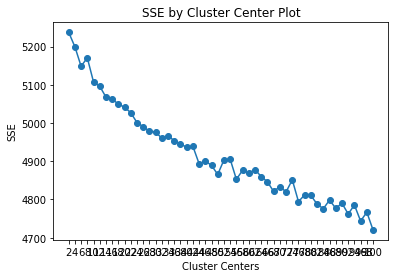

In [305]:
# Get 10-15 words with the highest TF-IDF values in each cluster'
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans

def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

find_optimal_clusters(X, 100)

In [ ]:
# Plot clusters on graph

